# Transformer 从零开始实现
论文：[Attention is All you Need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)

## 网络结构
<img src="./img/Transformer-1.png" width = "200" height = "300" alt="Transformer 网络结构" align=center />
<p>
Transformer的基本结构是 encoder-decoder 结构(N=6):<br>
encoder: 输入序列的表示 (x1,...,xn) -->连续序列的表示 z=(z1,...,zn)。<br>
decoder: z --> 输出序列 (y1,...,ym), 一次输出一个元素。<br>
上面每一步的模型都是自回归的(AR),每次输出一个元素都将该元素添加到下一轮的输入中。
</p>
<img src="./img/Transformer-3.png" width = "600" height = "200" alt="Transformer 网络结构" align=center />

## Attention
<img src="./img/Transformer-2.png" width = "400" height = "200" alt="Attention 结构" align=center />

attention可以被描述为: query x1 + (key, value) xN --> output x1

### Scaled Dot-Product Attention
$$
Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt d_k})V
\\
Q\in R^{b\times s_q\times d_q}
\\
K\in R^{b\times s_k\times d_k}
\\
V\in R^{b\times s_v\times d_v}
\\
d_q=d_k
\\
沿着每行应用softmax转换为概率分布
$$

### Multi-Head Attention
$$
MultiHead(Q,K,V)=Concat(head_1,...,head_h)W^O
\\
head_i=Attention(Q{W_i}^Q,K{W_i}^K,V{W_i}^V)
\\
h=8,d_k=d_v=d_{model}/h=64
\\
{W_i}^Q \in R^{d_{model}\times d_k}
\\
{W_i}^K \in R^{d_{model}\times d_k}
\\
{W_i}^V \in R^{d_{model}\times d_v}
\\
{W}^O \in R^{hd_{model}\times d_v}
$$

In [9]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display

In [4]:
def sequence_mask(X, valid_len, value=0):
    '''在序列中掩蔽不相关的项
    args:
        X:          tensor (batch_size * seq_len, d_model)
        valid_len:  tensor (batch_size * seq_len,)
    return:
        tensor (batch_size * seq_len, d_model)
    '''
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

sequence_mask(torch.tensor([[1,2,3],[4,5,6]]), torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [6]:
def masked_softmax(X, valid_lens):
    '''通过在最后一个轴上掩蔽元素来执行softmax操作
    args:
        X:          tensor (batch_size, seq_len, d_model)
        valid_lens: tensor (batch_size,) or (batch_size, seq_len)
    return:
        tensor (batch_size, seq_len, d_model)
    '''
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # d_model轴上被掩蔽的元素使用一个非常大的负值替换，从而使其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

masked_softmax(torch.rand(2,3,4), torch.tensor([2,3]))

tensor([[[0.2778, 0.7222, 0.0000, 0.0000],
         [0.5218, 0.4782, 0.0000, 0.0000],
         [0.6787, 0.3213, 0.0000, 0.0000]],

        [[0.2580, 0.4156, 0.3264, 0.0000],
         [0.2385, 0.3897, 0.3718, 0.0000],
         [0.3803, 0.2465, 0.3731, 0.0000]]])

In [ ]:
class DotProductAttention(nn.Module):
    '''缩放点积注意力'''
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens=None):
        '''
        args:
            queries:    tensor (batch_size, seq_len_q, d_model)
            keys:       tensor (batch_size, seq_len, d_model)
            values:     tensor (batch_size, seq_len, d_v)
            valid_lens: tensor (batch_size,) or (batch_size, seq_len)
        return:
            tensor (batch_size, seq_len_q, d_v)
        '''
        d = queries.shape[-1]
        
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)
    
queries     = torch.normal(0, 1, (2,3,10))
keys        = torch.normal(0, 1, (2,5,10))
values      = torch.normal(0, 1, (2,5,15))
valid_lens  = torch.tensor([3,8])
attetion    = DotProductAttention(dropout=0.5)
attetion.eval()
attetion(queries, keys, values, valid_lens).shape, attetion.attention_weights.shape

(torch.Size([2, 3, 15]), torch.Size([2, 3, 5]))

/tmp/ipykernel_1288944/772604025.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


tensor([[[0.4881, 0.1002, 0.4116, 0.0000, 0.0000],
         [0.1103, 0.4766, 0.4131, 0.0000, 0.0000],
         [0.3673, 0.2478, 0.3849, 0.0000, 0.0000]],

        [[0.0588, 0.0963, 0.1631, 0.5988, 0.0830],
         [0.1698, 0.2655, 0.1036, 0.0270, 0.4341],
         [0.5226, 0.2241, 0.0886, 0.1000, 0.0647]]])

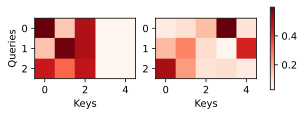

In [24]:
def use_svg_display():
    '''在jupyter中使用svg格式显示plot'''
    display.set_matplotlib_formats('svg')

def show_heatmaps(metrices, xlabel, ylabel, titles=None, figsize=(2.5,2.5), cmap='Reds'):
    '''显示矩阵热图
    args:
        metrices: tensor (plot_num, subplot_num or batch_size, seq_len_q, seq_len_k)
    '''
    use_svg_display()
    num_rows, num_cols = metrices.shape[0], metrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize[0]*num_cols, figsize[1]*num_rows),
                             sharex=False, sharey=False, squeeze=False)
    for i, (row_axes, row_metrices) in enumerate(zip(axes, metrices)):
        for j, (ax, matirx) in enumerate(zip(row_axes, row_metrices)):
            pcm = ax.imshow(matirx.numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)


show_heatmaps(attetion.attention_weights.reshape((1,2,3,5)), xlabel='Keys', ylabel='Queries')
attetion.attention_weights

In [55]:
class MultiHeadAttention(nn.Module):
    '''多头注意力'''
    def __init__(self, key_size, query_size, value_size, d_model, num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, d_model, bias=bias)
        self.W_k = nn.Linear(key_size, d_model, bias=bias)
        self.W_v = nn.Linear(value_size, d_model, bias=bias)
        self.W_o = nn.Linear(d_model, d_model, bias=bias)
    
    def forward(self, queries, keys, values, valid_lens):
        '''
        args:
            queries:    tensor (batch_size, seq_len_q, d_model)
            keys:       tensor (batch_size, seq_len, d_model)
            values:     tensor (batch_size, seq_len, d_v)
            valid_lens: tensor (batch_size,) or (batch_size, seq_len)
        return:
            tensor (batch_size, seq_len_q, d_v)
        '''
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_q(keys), self.num_heads)
        values = transpose_qkv(self.W_q(values), self.num_heads)
        
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        
        return self.W_o(output_concat)
        
        
    
def transpose_qkv(X:torch.Tensor, num_heads):
    '''为了多头注意力的并行计算而变换形状
    args:
        X: tensor (batch_size, seq_len, d_model)
    return:
        tensor (batch_size * num_heads, seq_len, d_model / num_heads)
    '''
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])
        

def transpose_output(X:torch.Tensor, num_heads):
    '''逆转transpose_qkv操作
    args:
        X: tensor (batch_size * num_heads, seq_len_q, d_v / num_heads)
    return:
        tensor (batch_size, seq_len_q, d_v)
    '''
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

num_hiddens, num_heads = 100, 5
attetion = MultiHeadAttention(key_size=num_hiddens, query_size=num_hiddens, value_size=num_hiddens, 
                              d_model=num_hiddens, num_heads=num_heads, dropout=0.5)

## Position-wise Feed-Forward Networks
$$
FFN(x)=max(0,xW_1+b_1)W_2+b2
\\
dim_{input}=dim_{output}=d_{model}=512
\\
dim_{innerlayer}=d_{ff}=2048
$$

In [26]:
class PositionWiseFNN(nn.Module):
    '''基于位置的前馈网络'''
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_output, **kwargs):
        super(PositionWiseFNN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_output)
        
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

ffn = PositionWiseFNN(4, 5, 6)
ffn.eval()
ffn(torch.ones(2, 3, 4)).shape

torch.Size([2, 3, 6])

## Embeddings and Softmax

## Positional Encoding
$$
PE(pos,2i)=sin(pos/10000^{2i/d_{model}})
\\
PE(pos,2i+1)=cos(pos/10000^{2i/d_{model}})
$$

In [40]:
def set_figsize(figsize=(3.5, 2.5)):
    '''为 matplotlib 设置画布尺寸'''
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    '''为 matplotlib 设置轴'''
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear', 
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    '''画出数据点'''
    if legend is None:
        legend = []
    
    set_figsize(figsize)
    axes = axes if axes else plt.gca()
    
    # 如果 X 只有一个轴则返回True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))
    
    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

/tmp/ipykernel_1288944/772604025.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


(torch.Size([60, 4]), torch.Size([4, 60]))

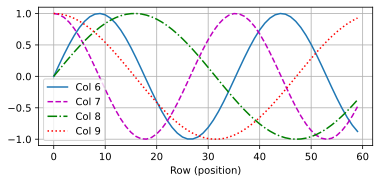

In [ ]:
class PositionalEncoding(nn.Module):
    '''位置编码'''
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) 
        X = X / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
    
    def forward(self, X):
        '''emb加入位置编码
        args:
            X: tensor (1, seq_len, d_model), d_model = num_hiddens
        return:
            tensor
        '''
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)


encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)', figsize=(6, 2.5), legend=['Col %d' % d for d in torch.arange(6,10)])
P[0, :, 6:10].shape, P[0, :, 6:10].T.shape

In [49]:
class AddNorm(nn.Module):
    '''残差连接 + 层归一化'''
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
X, Y = torch.arange(2*3*4*2, dtype=torch.float32).reshape(-1, 2, 3, 4)
add_norm(X, Y)

tensor([[[-1.5933, -1.3036, -1.0139, -0.7242],
         [-0.4345, -0.1448,  0.1448,  0.4345],
         [ 0.7242,  1.0139,  1.3036,  1.5933]],

        [[-1.5933, -1.3036, -1.0139, -0.7242],
         [-0.4345, -0.1448,  0.1448,  0.4345],
         [ 0.7242,  1.0139,  1.3036,  1.5933]]],
       grad_fn=<NativeLayerNormBackward0>)

In [ ]:
class EncoderBlock(nn.Module):
    '''Transformer 编码器块'''
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, 
                                            num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFNN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, valid_lens):
        '''
        args:
            X:          tensor (batch_size, seq_len, d_model)
            valid_lens: tensor (batch_size,) or (batch_size, seq_len)
        return:
            tensor (batch_size, seq_len, d_model)
        '''
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))
    

X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, 
                           [100, 24], 24, 48, 8,
                           0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [84]:
class DecoderBlock(nn.Module):
    '''Transformer 解码器块'''
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, 
                                            num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, 
                                            num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFNN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        
    
    def forward(self, X, state):
        '''
        args:
            X:          tensor (batch_size, seq_len, d_model)
            state:      list
                            0:enc_outputs:  tensor (batch_size, seq_len, d_model)
                            1:valid_lens:   tensor (batch_size,) or (batch_size, seq_len)
                            2:dec_outputs:  [tensor] (N, seq_len, d_model) or [None]
        return:
            X:          tensor (batch_size, seq_len, d_model)
            state:      list
                            0:enc_outputs:  tensor (batch_size, seq_len, d_model)
                            1:valid_lens:   tensor (batch_size,) or (batch_size, seq_len)
                            2:dec_outputs:  [tensor] (N, seq_len, d_model) or [None]
        '''
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，因此state[2][self.i]初始化为None
        # 预测阶段，输出序列是通过词元一个接着一个解码的，因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat(([state[2][self.i], X]), axis=1)
        state[2][self.i] = key_values
        
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_len = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_len = None
        
        X2 = self.attention1(X, key_values, key_values, dec_valid_len)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state
        

decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[1][2][0].shape, valid_lens.shape, state[0].shape

(torch.Size([2, 100, 24]), torch.Size([2]), torch.Size([2, 100, 24]))

In [70]:
class Encoder(nn.Module):
    '''base encoder'''
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
    
    def forward(self, X, *args):
        raise NotImplementedError

class Decoder(nn.Module):
    '''base encoder'''
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
    
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
        
    def forward(self, X, *args):
        raise NotImplementedError

class AttentionDecoder(Decoder):
    '''base attention-based decoder'''
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    
    @property
    def attetion_weights(self):
        raise NotImplementedError

In [ ]:
class TransformerEncoder(Encoder):
    '''Transformer 编码器'''
    def __init__(self, vocab_size, key_size, query_size, value_size, 
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, 
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module('block'+str(i),
                                 EncoderBlock(key_size, query_size, value_size, 
                                              num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, 
                                              num_heads, dropout, use_bias))
        
    def forward(self, X, valid_lens, *args):
        '''
        args:
            X:          tensor (batch_size, seq_len)
            valid_lens: tensor (batch_size,) or (batch_size, seq_len)
        return:
            X:          tensor (batch_size, seq_len, d_model)
        '''
        # 因为位置编码在[-1,1]，因此嵌入值乘以嵌入维度的平方根进行缩放，再与位置编码相加
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X
    

encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [88]:
class TransformerDecoder(AttentionDecoder):
    '''Transformer 解码器'''
    def __init__(self, vocab_size, key_size, query_size, value_size, 
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, 
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module('block'+str(i),
                                 DecoderBlock(key_size, query_size, value_size, 
                                              num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, 
                                              num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_len, *args):
        return [enc_outputs, enc_valid_len, [None] * self.num_layers]
    
    def forward(self, X, state):
        '''
        args:
            X:          tensor (batch_size, seq_len)
            state:      list
                            0:enc_outputs:  tensor (batch_size, seq_len, d_model)
                            1:valid_lens:   tensor (batch_size,) or (batch_size, seq_len)
                            2:dec_outputs:  [tensor] (N, seq_len, d_model) or [None]
        return:
            X:          tensor (batch_size, seq_len, d_model)
            state:      list
                            0:enc_outputs:  tensor (batch_size, seq_len, d_model)
                            1:valid_lens:   tensor (batch_size,) or (batch_size, seq_len)
                            2:dec_outputs:  [tensor] (N, seq_len, d_model) or [None]
        '''
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # 编码器-解码器自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights
    
    
decoder = TransformerDecoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
decoder.eval()
X = torch.ones((2, 100), dtype=torch.long)
state = [encoder(X, valid_lens), valid_lens, [None] * 8]
decoder(X, state)[0].shape, decoder(X, state)[1][0].shape, decoder(X, state)[1][1].shape, decoder(X, state)[1][2][0].shape 

(torch.Size([2, 100, 200]),
 torch.Size([2, 100, 24]),
 torch.Size([2]),
 torch.Size([2, 400, 24]))

# Bert